<center>
<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
</center>
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Week 10 Tutorial: Gradient Boosting</h2>
<br>



Gradient boosting is one the most powerful algorithms available for supervised learning. For many business applications, carefully tuned boosted trees are likely to be among the best models immediately available for prediction.

A large scale empirical study by [Caruana and Niculescu-Mizil (2006)](https://dl.acm.org/ft_gateway.cfm?id=1143865&ftid=364245&dwn=1&CFID=7573757&CFTOKEN=aea5af1b7b29f94-E2D75B9E-EE4F-186B-FF2FDBF1F8C435D1) found that boosting was overall the most accurate algorithm for supervised learning across a variety of datasets, among competitors that included random forests, support vector machines, and neural networks.  Boosting is also behind [winning solutions](https://github.com/dmlc/xgboost/tree/master/demo#machine-learning-challenge-winning-solutions) to several machine learning competitions. 

In this lesson we will study a regression problem to illustrate how to using boosting with Python. Due to the importance of this topic, we will move beyond scikit-Learn to consider three specialised packages for boosting: [XGBoost](http://xgboost.readthedocs.io/en/latest/model.html), [LightGBM](https://github.com/Microsoft/LightGBM), and [CatBoost](https://catboost.ai/).  

<a href="#1.-California-Housing-Data">California Housing Data</a> <br>
<a href="#2.-Exploratory-data-analysis">Exploratory Data Analysis</a> <br>
<a href="#3.-Random forest">Boosting</a> <br>
<a href="#4.-LightGBM:-a-deeper-dive<">LightGBM: a deeper dive</a> <br>
<a href="#5.-Benchmark-Models">Benchmark models</a> <br>
<a href="#6.-Model-selection">Model selection</a> <br>

This notebook relies on the following libraries and settings.

In [1]:
# Requirements 

import numpy as np
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy
import sklearn
import xgboost as xgb
import lightgbm as lgb
import catboost
import optuna

print(f'Package versions: \n')

print(f'numpy {np.__version__}')
print(f'scipy {scipy.__version__}')
print(f'pandas {pd.__version__}')
print(f'seaborn {sns.__version__}')
print(f'cartopy {cartopy.__version__}')
print(f'scikit-learn {sklearn.__version__}')
print(f'xgboost {xgb.__version__}')
print(f'lightgbm {lgb.__version__}')
print(f'catboost {catboost.__version__}')
print(f'optuna {optuna.__version__}')

# Notebook tested on:

# numpy 1.21.5
# scipy 1.7.1
# pandas 1.3.4
# seaborn 0.11.2
# cartopy 0.20.2
# scikit-learn 1.0.2
# xgboost 1.5.2
# lightgbm 3.3.2
# catboost 1.0.4
# optuna 2.10.0

Package versions: 

numpy 1.20.3
scipy 1.7.3
pandas 1.2.5
seaborn 0.11.1
cartopy 0.18.0
scikit-learn 1.0.2
xgboost 1.5.2
lightgbm 3.2.1
catboost 0.26.1
optuna 2.9.1


In [2]:
# Optional configuration

# This is to clear the warnings from the notebook, usually we should leave this on
import warnings
warnings.filterwarnings('ignore')

# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
           '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
# Methods
from sklearn.linear_model import LinearRegression

# Model selection and evaluation tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

In [4]:
# Useful code from the last tutorial 

from tutorial9 import plot_feature_importance

# 1. California Housing Data

We use the California housing dataset, which we can obtain directly from the Scikit-Learn distribution. 

In [5]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()

print(data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [6]:
# Auxiliary code - important to understand but similar to previous tutorials

data = pd.DataFrame(np.c_[data.data, data.target], columns = data.feature_names + ['MedianHouseValue'])
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


The following cell identifies the variables and splits the data into training and test samples. Note that: 

* The training set is only a small fraction of the data. This is to reduce the running times during our session, since the original dataset is large (20,640 observations) and methods such as random forests and boosting are computationally intensive.<br/>

* The response is very right skewed, so that we work with work with its log transformation. 

In [7]:
# Auxiliary code - important to understand but similar to previous tutorials

response = data.columns[-1] # last column in the dataframe
predictors= list(data.columns[:-1]) # all columns except the last
    
index_train, index_valid = train_test_split(np.array(data.index), train_size=0.2, random_state=1)

train = data.loc[index_train,:].copy()
valid = data.loc[index_valid,:].copy()

y_train = np.log(train[response])
y_valid = np.log(valid[response])

X_train = train[predictors].to_numpy()
X_valid = valid[predictors].to_numpy()

# 2. Some EDA

A key feature of this dataset is the presence of geographical information. The next cell draws a map to allow us to visualise the relationship between location and median house prices.  Warmer colours indicate higher prices, while the size of the bubbles indicates the population of the area.  

As we might expect, house prices are higher near the coast, around the Bay area, and around Los Angeles.  As we will see, these geographical patterns will be crucial achieving higher predictive accuracy. 

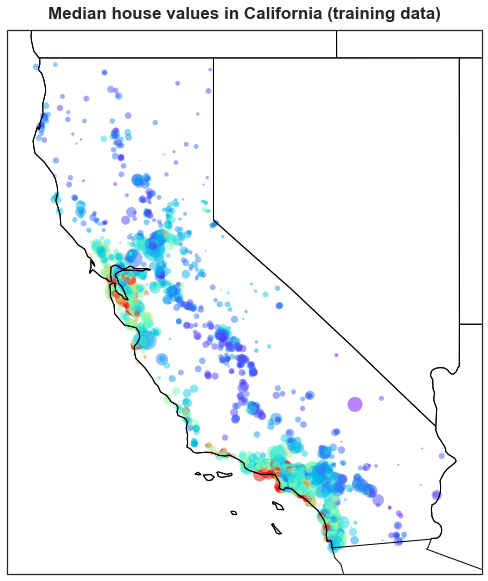

In [8]:
# This code is just for running - advanced code

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Latitude and longitude for the edges of the map
lat1, lat2, lon1, lon2 = 32, 42.5, -125, -114

# Create figures
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Mercator())

# Get latitude and longitude for each data point
x, y = (train['Longitude'].to_numpy(), train['Latitude'].to_numpy())

# Scatter plot as heat map
ax.scatter(x, y, s=(train['Population'].to_numpy()/30.0), c=train['MedianHouseValue'].to_numpy(), 
           edgecolors='none', cmap=plt.get_cmap('rainbow'), alpha=0.5, transform=ccrs.PlateCarree())

# Add state borders and coast line
ax.add_feature(cfeature.STATES.with_scale('50m'))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.set_extent([-125, -113.5, 32, 42.5], crs=ccrs.PlateCarree())

# Add title
ax.set_title('Median house values in California (training data)', fontsize=17, y=1.01, fontweight='bold')

plt.show()

The two variables with strongest linear relationship with house values are the median income and the average occupancy. Further exploration through the scatter plots below reveal nonlinear patterns for the median income, average rooms, and average occupancy. Population, housing average age, and average bedrooms seem to have only weak relationships with house values. 

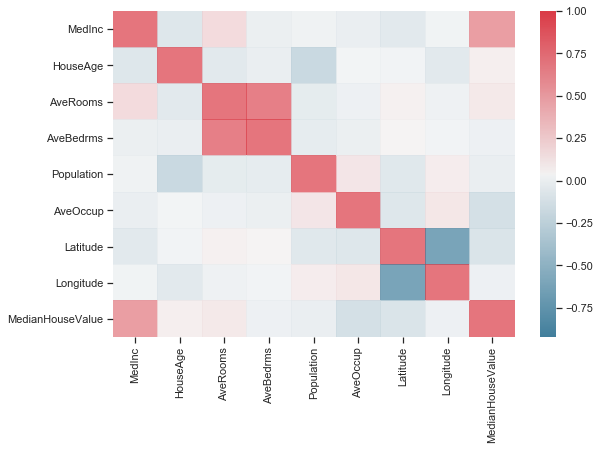

In [9]:
# This code is just for running - we need the figure to support the discussion

sns.heatmap(train.corr(), cmap=sns.diverging_palette(230, 10, n=1001), alpha=0.7)
plt.show()

The next cell shows the scatter plots for the predictors other than the latitude and longitude. We observe severe outliers in some of them, which as we will see below causes serious problems for the linear regression model. In contrast, tree-based methods are outliers in the predictor space.  We can also that the values of the `MedInc` response variable and `HouseAge` are truncated.

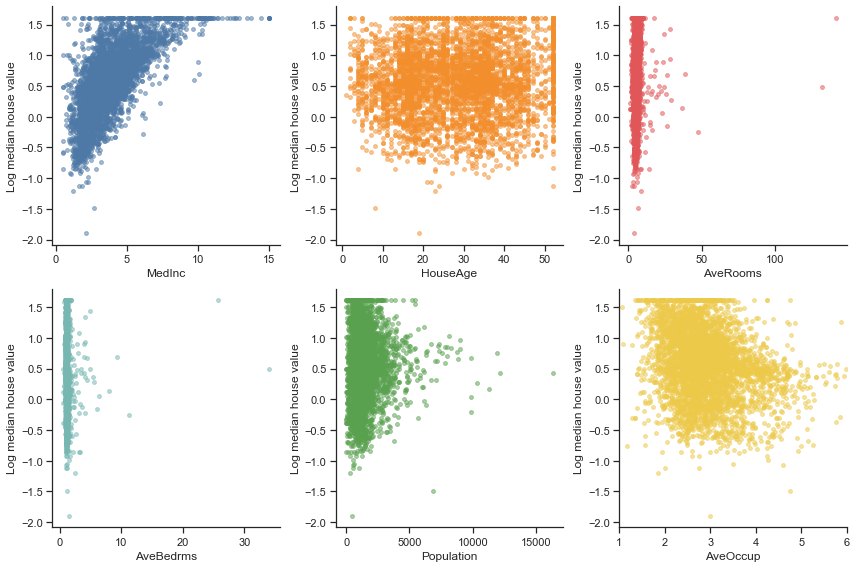

In [11]:
# This code is  just for running - we need the figure to support the discussion

fig, axes = plt.subplots(2,3, figsize=(12,8))

for i, ax in enumerate(fig.axes):
    sns.regplot(train.iloc[:,i], y_train, color=colours[i], scatter_kws={'s': 15, 'alpha': 0.5}, 
                ax=ax, fit_reg=False)
    ax.set_ylabel('Log median house value')

ax.set_xlim(1, 6) # fixes a bug in the last plot

sns.despine()
plt.tight_layout()
plt.show()

# 3. Boosting

This section focuses on the simplest ways of fitting boosted tree models: scikit-learn, the scikit-learn APIs for XGBoost and LightGBM, and CatBoost. 

## 3.1 Scikit-Learn

We start with the scikit-learn implementation of boosting available in the [<TT>GradientBoostingRegressor</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) class. Recall that boosting has three crucial hyperparameters:

<ol>
<li style="margin-top:15px; margin-bottom: 10px"> The learning rate.</li> 

<li style="margin-top:10px; margin-bottom: 10px"> The number of boosting of iterations (the number trees).</li> 

<li style="margin-top:10px; margin-bottom: 10px"> The size of each tree.</li> 
</ol>

In addition, we may want to to fit each tree on a different subsample of the training data.

The basic syntax is as follows. This section uses pre-selected hyperparameters to save time. The next section will dicuss hyperparameter optimisation for boosting in detail.

In [14]:
%%time

from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(learning_rate=0.01, max_depth=8, n_estimators=1901, subsample=0.596)
gb.fit(X_train, y_train)

CPU times: user 18.1 s, sys: 82 ms, total: 18.2 s
Wall time: 18.2 s


GradientBoostingRegressor(learning_rate=0.01, max_depth=8, n_estimators=1901,
                          subsample=0.596)

We can make a variable importance plot to help with interpretation.

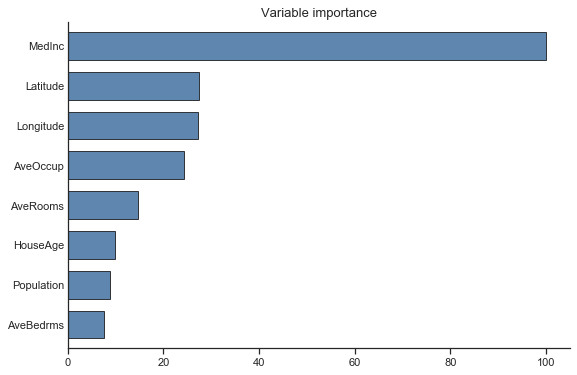

In [15]:
plot_feature_importance(gb, predictors)
plt.show()

Scikit-learn recently introduced the [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html) class, a histogram-based implementation of boosting inspired by LightGBM.  This implementation is significantly faster than `GradientBoostingRegressor` for large datasets.

The available hyperparameters are a bit different for `HistGradientBoostingRegressor`, see the documentation for details.

In [16]:
%%time

from sklearn.ensemble import HistGradientBoostingRegressor

hgb = HistGradientBoostingRegressor(learning_rate=0.01, max_depth=8, max_iter=1901)
hgb.fit(X_train, y_train)

CPU times: user 41.8 s, sys: 887 ms, total: 42.6 s
Wall time: 5.62 s


HistGradientBoostingRegressor(learning_rate=0.01, max_depth=8, max_iter=1901)

## 3.2 XGBoost (scikit-learn API)

[XGBoost](https://xgboost.readthedocs.io/en/latest/) is a state-of-art gradient boosting library that is very popular among data scientists and [Kaggle](https://www.kaggle.com/) users. 

The easiest way to get started with XGBoost is to use the [scikit-learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn) provided by the package. The syntax is similar to the one from the previous section, except that we call the [XGBRegressor](http://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor) class from the XGBoost package. 

XGBoost has significantly more [hyperparameters and options](https://xgboost.readthedocs.io/en/latest/parameter.html) than the scikit-learn implementations of boosting. The code shows the hyperparameters and settings that are most commonly adjusted.

In [19]:
%%time

import xgboost as xgb

xgbst = xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree', 
                         learning_rate=0.02, max_depth=6, n_estimators=1822, subsample=0.60,
                         reg_lambda=0.0, reg_alpha=0.0, 
                         colsample_bytree=1.0, min_child_weight=1.0)

# n_estimators: number of trees
# subsample: fraction of observations used to fit each tree
# reg_lambda: L2 regularisation penalty
# reg_alpha: L1 regularisation penalty
# colsample_bytree: fraction of features considered for each tree (alternatives: bylevel, bynode)
# min_child_weight: approximately equal to the minimum number of samples in each node

xgbst.fit(X_train, y_train)

AttributeError: dlsym(0x21b9d7aa0, XGDMatrixCreateFromDense): symbol not found

Other useful features supported by this API include: 

* Early stopping (we'll cover this below in the context of LightGBM).

* Pruning (the `gamma` parameter is a penalty for the number of leaves).
                  
* Mononicity constraints.

* Interaction contraints.

* GPU training.

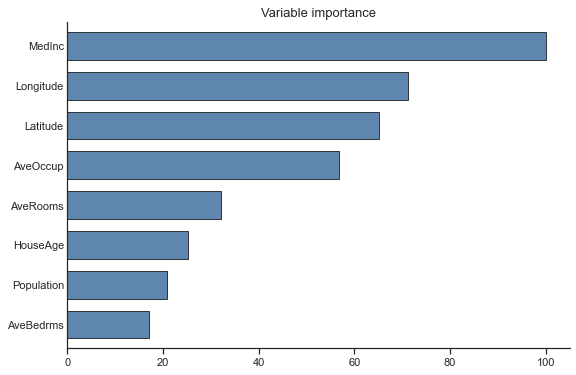

In [15]:
plot_feature_importance(xgbst, labels=predictors)
plt.show()

## 3.3 LightGBM (scikit-Learn API)

[LightGBM](http://lightgbm.readthedocs.io/en/latest/index.html) is a gradient boosting library developed by Microsoft. Similarly to XGBoost, it has a [scikit-learn API](http://lightgbm.readthedocs.io/en/latest/Python-API.html#scikit-learn-api) that makes it simple to use. Conveniently, the implementation is very computationally efficient. 

Like XGBoost, LightGBM has a [large number](https://lightgbm.readthedocs.io/en/latest/Parameters.html) of configuration options. The code highlights the most important parameters to pay attention to.

Because of the way LightGBM [works](https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc), we set the number of leaves rather than the maximum tree depth as in XGBoost. 

In [20]:
%%time

import lightgbm as lgb

lgbm = lgb.LGBMRegressor(objective='regression', boosting_type='gbdt', 
                         n_estimators=1974, learning_rate=0.01,  
                         num_leaves=24,
                         lambda_l1=0.0, lambda_l2=0.0,
                         bagging_fraction=0.74, bagging_freq=1, 
                         feature_fraction=1.0, min_data_in_leaf=1)

lgbm = lgbm.fit(X_train, y_train)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.74, subsample=1.0 will be ignored. Current value: bagging_fraction=0.74
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
CPU times: user 8.26 s, sys: 103 ms, total: 8.36 s
Wall time: 1.11 s


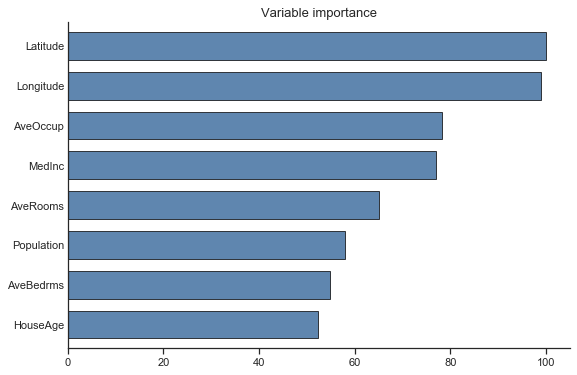

In [21]:
plot_feature_importance(lgbm, labels=predictors)
plt.show()

## 3.4 CatBoost

[CatBoost](https://catboost.ai/) is another important gradient boosting library. The main advantages of CatBoost is its great support for categorical features and computational speed. 

We use the [CatBoostRegressor](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor) class, which works like a scikit-learn estimator. See the [documentation](https://catboost.ai/en/docs/references/training-parameters/) for the full list of parameters. 

The following cell is just to illustrate the syntax.

In [22]:
%%time

from catboost import CatBoostRegressor

cb = CatBoostRegressor(loss_function='RMSE', 
                       iterations=2000, learning_rate=0.01,
                       l2_leaf_reg=0.0,
                       max_depth=6, 
                       subsample=0.8,
                       verbose=0)
        
cb.fit(X_train, y_train)

# Important! If there were categorical features, you'd want to change the code to
# cb.fit(X_train, y_train, cat_features = cat_indices)
# where cat_indices is a one-dimensional array of indices indicating the categorical columns in X_train

CPU times: user 13.6 s, sys: 579 ms, total: 14.1 s
Wall time: 2.52 s


The CatBoost [website](https://catboost.ai/) claims that the package tends to provide great results even with default parameters. Let's test this.

In [23]:
cb = CatBoostRegressor(loss_function='RMSE', verbose=0)        
cb.fit(X_train, y_train)

# 4 Deep Dive:  LightGBM

LightGBM, XGBoost, and CatBoost are extremely useful libraries at the forefront of current machine learning practice. Therefore, you should try to learn at least one of these three packages as deeply as you can.

Because we only have time for one, we'll cover LightGBM. However, XGBoost and CatBoost are just as good. Either of the three may perform best for a given problem.

## 4.1 Training API 

We now use switch to native LightGBM API, which is faster and worth learning. First, we need to convert the dataset into the LightGBM format. The LightGBM format is optimised for the learning algorithm and consumes less memory, which is important if you're working with large datasets.

In [24]:
train_data = lgb.Dataset(X_train, y_train)
valid_data = lgb.Dataset(X_valid, y_valid, reference=train_data)

# An important detail that is not applicable to this tutorial is that LightGBM can handle
# categorical features in a specialised way without the need for prior encoding.

# Suppose that that the first two columns of X_train are categorical. You'd then run:
# train_data = lgb.Dataset(X_train, y_train, categorical_feature = [0, 1])

# Alternatively, you can pass the list of categorical features to the train function below

To train the model, we create a dictionary with the hyperparameters and settings and pass it the train function. As an additional detail, we also pass the validation set for evaluation. 

See the [documentation](https://lightgbm.readthedocs.io/en/latest/Parameters.html#) for the full list of parameters. 

In [25]:
%%time

params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'l2',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'lambda_l1': 0.0, 
    'lambda_l2': 0.0, 
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'feature_fraction': 0.9,
    'min_data_in_leaf': 20, 
}

evals = {} 

lgbm = lgb.train(params, train_data, num_boost_round=2000, valid_sets=[train_data, valid_data], 
                 valid_names=['Training', 'Validation'], evals_result=evals)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 4128, number of used features: 8
[LightGBM] [Info] Start training from score 0.573084
[1]	Training's l2: 0.317312	Validation's l2: 0.320228
[2]	Training's l2: 0.313352	Validation's l2: 0.316392
[3]	Training's l2: 0.309144	Validation's l2: 0.312346
[4]	Training's l2: 0.305328	Validation's l2: 0.308652
[5]	Training's l2: 0.301519	Validation's l2: 0.30503
[6]	Training's l2: 0.297377	Validation's l2: 0.300985
[7]	Training's l2: 0.29339	Validation's l2: 0.297044
[8]	Training's l2: 0.289693	Validation's l2: 0.293473
[9]	Training's l2: 0.285778	Validation's l2: 0.289653
[10]	Training's l2: 0.282222	Validation's l2: 0.286211
[11]	Training's l2: 0.278775	Validation's l2: 0.282902
[12]	Training's l2: 0.2754	Validation's l2: 0.279633
[13]	Train

[175]	Training's l2: 0.0735336	Validation's l2: 0.0863349
[176]	Training's l2: 0.0732688	Validation's l2: 0.0861247
[177]	Training's l2: 0.0730196	Validation's l2: 0.0859054
[178]	Training's l2: 0.0727079	Validation's l2: 0.0856098
[179]	Training's l2: 0.0723987	Validation's l2: 0.0853346
[180]	Training's l2: 0.0720972	Validation's l2: 0.0850555
[181]	Training's l2: 0.0718	Validation's l2: 0.0847828
[182]	Training's l2: 0.0715598	Validation's l2: 0.0845702
[183]	Training's l2: 0.0712668	Validation's l2: 0.0843049
[184]	Training's l2: 0.0709762	Validation's l2: 0.0840439
[185]	Training's l2: 0.0707329	Validation's l2: 0.0838433
[186]	Training's l2: 0.070514	Validation's l2: 0.0836712
[187]	Training's l2: 0.0702579	Validation's l2: 0.0834493
[188]	Training's l2: 0.0700352	Validation's l2: 0.083266
[189]	Training's l2: 0.069772	Validation's l2: 0.0830364
[190]	Training's l2: 0.0695273	Validation's l2: 0.0828245
[191]	Training's l2: 0.0693031	Validation's l2: 0.0826399
[192]	Training's l2:

[317]	Training's l2: 0.0484265	Validation's l2: 0.0649154
[318]	Training's l2: 0.048327	Validation's l2: 0.0648243
[319]	Training's l2: 0.0482573	Validation's l2: 0.0647886
[320]	Training's l2: 0.0481222	Validation's l2: 0.0646645
[321]	Training's l2: 0.0480143	Validation's l2: 0.0645874
[322]	Training's l2: 0.047919	Validation's l2: 0.0645131
[323]	Training's l2: 0.0478113	Validation's l2: 0.0644351
[324]	Training's l2: 0.0477353	Validation's l2: 0.0644053
[325]	Training's l2: 0.0476462	Validation's l2: 0.0643341
[326]	Training's l2: 0.047573	Validation's l2: 0.0642983
[327]	Training's l2: 0.0474973	Validation's l2: 0.0642547
[328]	Training's l2: 0.0474108	Validation's l2: 0.064204
[329]	Training's l2: 0.0473289	Validation's l2: 0.06414
[330]	Training's l2: 0.047263	Validation's l2: 0.0641048
[331]	Training's l2: 0.0471447	Validation's l2: 0.0639925
[332]	Training's l2: 0.0470302	Validation's l2: 0.0638833
[333]	Training's l2: 0.0469175	Validation's l2: 0.0637762
[334]	Training's l2: 

[485]	Training's l2: 0.0373589	Validation's l2: 0.0576331
[486]	Training's l2: 0.0373245	Validation's l2: 0.0576214
[487]	Training's l2: 0.0372922	Validation's l2: 0.057616
[488]	Training's l2: 0.0372565	Validation's l2: 0.0576038
[489]	Training's l2: 0.0372257	Validation's l2: 0.0575906
[490]	Training's l2: 0.0371911	Validation's l2: 0.0575786
[491]	Training's l2: 0.0371538	Validation's l2: 0.0575567
[492]	Training's l2: 0.037113	Validation's l2: 0.057544
[493]	Training's l2: 0.0370697	Validation's l2: 0.0575163
[494]	Training's l2: 0.0370347	Validation's l2: 0.057502
[495]	Training's l2: 0.0369999	Validation's l2: 0.0574897
[496]	Training's l2: 0.0369532	Validation's l2: 0.0574715
[497]	Training's l2: 0.0369062	Validation's l2: 0.0574474
[498]	Training's l2: 0.0368605	Validation's l2: 0.0574296
[499]	Training's l2: 0.036819	Validation's l2: 0.0574191
[500]	Training's l2: 0.036775	Validation's l2: 0.0573985
[501]	Training's l2: 0.0367356	Validation's l2: 0.0573881
[502]	Training's l2:

[650]	Training's l2: 0.0317501	Validation's l2: 0.0556985
[651]	Training's l2: 0.0317211	Validation's l2: 0.055694
[652]	Training's l2: 0.0316926	Validation's l2: 0.0556911
[653]	Training's l2: 0.0316631	Validation's l2: 0.0556895
[654]	Training's l2: 0.0316376	Validation's l2: 0.0556868
[655]	Training's l2: 0.0316073	Validation's l2: 0.0556833
[656]	Training's l2: 0.0315761	Validation's l2: 0.0556656
[657]	Training's l2: 0.0315441	Validation's l2: 0.0556536
[658]	Training's l2: 0.0315192	Validation's l2: 0.0556454
[659]	Training's l2: 0.0314938	Validation's l2: 0.055644
[660]	Training's l2: 0.0314642	Validation's l2: 0.0556346
[661]	Training's l2: 0.0314368	Validation's l2: 0.0556233
[662]	Training's l2: 0.0314019	Validation's l2: 0.0556102
[663]	Training's l2: 0.0313775	Validation's l2: 0.055606
[664]	Training's l2: 0.0313481	Validation's l2: 0.0555943
[665]	Training's l2: 0.0313265	Validation's l2: 0.0555955
[666]	Training's l2: 0.0313017	Validation's l2: 0.0555894
[667]	Training's 

[810]	Training's l2: 0.0277885	Validation's l2: 0.0546609
[811]	Training's l2: 0.0277664	Validation's l2: 0.054659
[812]	Training's l2: 0.0277429	Validation's l2: 0.054657
[813]	Training's l2: 0.0277204	Validation's l2: 0.0546507
[814]	Training's l2: 0.0276957	Validation's l2: 0.054641
[815]	Training's l2: 0.0276716	Validation's l2: 0.0546311
[816]	Training's l2: 0.027652	Validation's l2: 0.0546276
[817]	Training's l2: 0.027633	Validation's l2: 0.0546233
[818]	Training's l2: 0.0276109	Validation's l2: 0.0546208
[819]	Training's l2: 0.0275905	Validation's l2: 0.0546165
[820]	Training's l2: 0.0275686	Validation's l2: 0.0546068
[821]	Training's l2: 0.0275449	Validation's l2: 0.0545994
[822]	Training's l2: 0.0275203	Validation's l2: 0.0545936
[823]	Training's l2: 0.0275005	Validation's l2: 0.0545882
[824]	Training's l2: 0.0274761	Validation's l2: 0.0545841
[825]	Training's l2: 0.027457	Validation's l2: 0.0545783
[826]	Training's l2: 0.0274325	Validation's l2: 0.0545628
[827]	Training's l2:

[983]	Training's l2: 0.0244733	Validation's l2: 0.0539181
[984]	Training's l2: 0.0244554	Validation's l2: 0.0539118
[985]	Training's l2: 0.0244333	Validation's l2: 0.0539069
[986]	Training's l2: 0.0244188	Validation's l2: 0.0539077
[987]	Training's l2: 0.0244012	Validation's l2: 0.0539051
[988]	Training's l2: 0.0243875	Validation's l2: 0.0539061
[989]	Training's l2: 0.0243677	Validation's l2: 0.0538976
[990]	Training's l2: 0.024352	Validation's l2: 0.0538968
[991]	Training's l2: 0.0243371	Validation's l2: 0.0538969
[992]	Training's l2: 0.0243221	Validation's l2: 0.053896
[993]	Training's l2: 0.0243025	Validation's l2: 0.0538886
[994]	Training's l2: 0.0242893	Validation's l2: 0.0538881
[995]	Training's l2: 0.0242712	Validation's l2: 0.0538879
[996]	Training's l2: 0.024252	Validation's l2: 0.0538853
[997]	Training's l2: 0.0242355	Validation's l2: 0.0538863
[998]	Training's l2: 0.024219	Validation's l2: 0.0538854
[999]	Training's l2: 0.0242035	Validation's l2: 0.0538848
[1000]	Training's 

[1159]	Training's l2: 0.0217387	Validation's l2: 0.0535294
[1160]	Training's l2: 0.0217247	Validation's l2: 0.0535289
[1161]	Training's l2: 0.0217102	Validation's l2: 0.053527
[1162]	Training's l2: 0.0216946	Validation's l2: 0.0535239
[1163]	Training's l2: 0.0216779	Validation's l2: 0.0535227
[1164]	Training's l2: 0.0216623	Validation's l2: 0.0535211
[1165]	Training's l2: 0.0216474	Validation's l2: 0.0535189
[1166]	Training's l2: 0.0216315	Validation's l2: 0.0535155
[1167]	Training's l2: 0.0216165	Validation's l2: 0.0535156
[1168]	Training's l2: 0.0216021	Validation's l2: 0.0535141
[1169]	Training's l2: 0.0215875	Validation's l2: 0.0535145
[1170]	Training's l2: 0.0215725	Validation's l2: 0.0535146
[1171]	Training's l2: 0.0215609	Validation's l2: 0.0535106
[1172]	Training's l2: 0.021549	Validation's l2: 0.0535087
[1173]	Training's l2: 0.0215379	Validation's l2: 0.053505
[1174]	Training's l2: 0.0215263	Validation's l2: 0.0535061
[1175]	Training's l2: 0.0215123	Validation's l2: 0.0535018


[1446]	Training's l2: 0.0182589	Validation's l2: 0.053007
[1447]	Training's l2: 0.0182434	Validation's l2: 0.0530055
[1448]	Training's l2: 0.018231	Validation's l2: 0.053007
[1449]	Training's l2: 0.018216	Validation's l2: 0.0530055
[1450]	Training's l2: 0.0182081	Validation's l2: 0.053005
[1451]	Training's l2: 0.0181951	Validation's l2: 0.0530039
[1452]	Training's l2: 0.0181829	Validation's l2: 0.0530031
[1453]	Training's l2: 0.0181702	Validation's l2: 0.0530041
[1454]	Training's l2: 0.01816	Validation's l2: 0.0530051
[1455]	Training's l2: 0.0181476	Validation's l2: 0.0530057
[1456]	Training's l2: 0.0181377	Validation's l2: 0.053004
[1457]	Training's l2: 0.0181279	Validation's l2: 0.0530025
[1458]	Training's l2: 0.0181191	Validation's l2: 0.0530006
[1459]	Training's l2: 0.0181106	Validation's l2: 0.0529988
[1460]	Training's l2: 0.018101	Validation's l2: 0.0529978
[1461]	Training's l2: 0.0180887	Validation's l2: 0.0529968
[1462]	Training's l2: 0.018079	Validation's l2: 0.0529933
[1463]	

[1602]	Training's l2: 0.0166812	Validation's l2: 0.0528889
[1603]	Training's l2: 0.0166739	Validation's l2: 0.0528882
[1604]	Training's l2: 0.0166658	Validation's l2: 0.0528917
[1605]	Training's l2: 0.0166572	Validation's l2: 0.0528925
[1606]	Training's l2: 0.016647	Validation's l2: 0.0528939
[1607]	Training's l2: 0.0166381	Validation's l2: 0.0528955
[1608]	Training's l2: 0.016628	Validation's l2: 0.0528963
[1609]	Training's l2: 0.0166187	Validation's l2: 0.0528966
[1610]	Training's l2: 0.0166101	Validation's l2: 0.0528965
[1611]	Training's l2: 0.0166021	Validation's l2: 0.0528936
[1612]	Training's l2: 0.0165957	Validation's l2: 0.0528933
[1613]	Training's l2: 0.0165885	Validation's l2: 0.0528919
[1614]	Training's l2: 0.0165808	Validation's l2: 0.0528893
[1615]	Training's l2: 0.0165736	Validation's l2: 0.0528879
[1616]	Training's l2: 0.0165639	Validation's l2: 0.0528841
[1617]	Training's l2: 0.0165555	Validation's l2: 0.052882
[1618]	Training's l2: 0.0165459	Validation's l2: 0.0528772


[1791]	Training's l2: 0.015032	Validation's l2: 0.0527408
[1792]	Training's l2: 0.0150203	Validation's l2: 0.052731
[1793]	Training's l2: 0.0150131	Validation's l2: 0.052734
[1794]	Training's l2: 0.0150061	Validation's l2: 0.0527379
[1795]	Training's l2: 0.0149996	Validation's l2: 0.0527367
[1796]	Training's l2: 0.0149907	Validation's l2: 0.0527362
[1797]	Training's l2: 0.0149821	Validation's l2: 0.052735
[1798]	Training's l2: 0.0149721	Validation's l2: 0.0527338
[1799]	Training's l2: 0.0149648	Validation's l2: 0.0527348
[1800]	Training's l2: 0.0149551	Validation's l2: 0.0527335
[1801]	Training's l2: 0.0149472	Validation's l2: 0.0527325
[1802]	Training's l2: 0.0149391	Validation's l2: 0.0527359
[1803]	Training's l2: 0.0149308	Validation's l2: 0.052739
[1804]	Training's l2: 0.0149225	Validation's l2: 0.052738
[1805]	Training's l2: 0.0149146	Validation's l2: 0.0527378
[1806]	Training's l2: 0.014907	Validation's l2: 0.0527366
[1807]	Training's l2: 0.0148974	Validation's l2: 0.0527351
[180

[1995]	Training's l2: 0.0135022	Validation's l2: 0.0526574
[1996]	Training's l2: 0.013493	Validation's l2: 0.0526593
[1997]	Training's l2: 0.0134848	Validation's l2: 0.052662
[1998]	Training's l2: 0.0134767	Validation's l2: 0.0526601
[1999]	Training's l2: 0.0134691	Validation's l2: 0.0526621
[2000]	Training's l2: 0.0134599	Validation's l2: 0.0526608
CPU times: user 18.6 s, sys: 592 ms, total: 19.2 s
Wall time: 2.57 s


The `plot_metric` function allows you to plot the training and validation errors against the number of trees. Fortunately, boosting is slow to overfit.

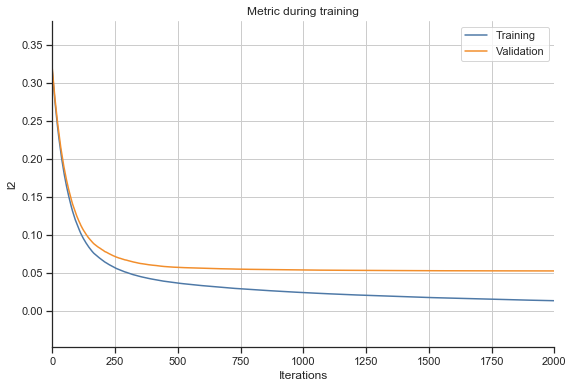

In [26]:
lgb.plot_metric(evals, metric='l2')
sns.despine()
plt.show()

## 4.2 Early stopping 

In the following example, we activate early stopping by setting the `early_stopping_rounds` parameter. In this case, LightGBM will stop training when the validation scores don't improve for 50 iterations. 

In [27]:
%%time

params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'lambda_l1': 0.0, 
    'lambda_l2': 0.0, 
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'feature_fraction': 0.9,
    'min_data_in_leaf': 20,
    'verbosity': 1
}

evals = {} 

lgbm = lgb.train(params, train_data, num_boost_round=5000,  valid_sets=[train_data, valid_data], 
                 valid_names=['Training', 'Validation'], early_stopping_rounds=100,  evals_result=evals)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 4128, number of used features: 8
[LightGBM] [Info] Start training from score 0.573084
[1]	Training's l2: 0.317312	Validation's l2: 0.320228
Training until validation scores don't improve for 100 rounds
[2]	Training's l2: 0.313352	Validation's l2: 0.316392
[3]	Training's l2: 0.309144	Validation's l2: 0.312346
[4]	Training's l2: 0.305328	Validation's l2: 0.308652
[5]	Training's l2: 0.301519	Validation's l2: 0.30503
[6]	Training's l2: 0.297377	Validation's l2: 0.300985
[7]	Training's l2: 0.29339	Validation's l2: 0.297044
[8]	Training's l2: 0.289693	Validation's l2: 0.293473
[9]	Training's l2: 0.285778	Validation's l2: 0.289653
[10]	Training's l2: 0.282222	Validation's l2: 0.286211
[11]	Training's l2: 0.278775	Validation's l2: 0.282902
[

[167]	Training's l2: 0.0758765	Validation's l2: 0.0884293
[168]	Training's l2: 0.0755899	Validation's l2: 0.0881823
[169]	Training's l2: 0.0752865	Validation's l2: 0.087915
[170]	Training's l2: 0.0749911	Validation's l2: 0.0876554
[171]	Training's l2: 0.074722	Validation's l2: 0.0874157
[172]	Training's l2: 0.0744021	Validation's l2: 0.0871129
[173]	Training's l2: 0.0740967	Validation's l2: 0.086829
[174]	Training's l2: 0.0737959	Validation's l2: 0.0865577
[175]	Training's l2: 0.0735336	Validation's l2: 0.0863349
[176]	Training's l2: 0.0732688	Validation's l2: 0.0861247
[177]	Training's l2: 0.0730196	Validation's l2: 0.0859054
[178]	Training's l2: 0.0727079	Validation's l2: 0.0856098
[179]	Training's l2: 0.0723987	Validation's l2: 0.0853346
[180]	Training's l2: 0.0720972	Validation's l2: 0.0850555
[181]	Training's l2: 0.0718	Validation's l2: 0.0847828
[182]	Training's l2: 0.0715598	Validation's l2: 0.0845702
[183]	Training's l2: 0.0712668	Validation's l2: 0.0843049
[184]	Training's l2:

[328]	Training's l2: 0.0474108	Validation's l2: 0.064204
[329]	Training's l2: 0.0473289	Validation's l2: 0.06414
[330]	Training's l2: 0.047263	Validation's l2: 0.0641048
[331]	Training's l2: 0.0471447	Validation's l2: 0.0639925
[332]	Training's l2: 0.0470302	Validation's l2: 0.0638833
[333]	Training's l2: 0.0469175	Validation's l2: 0.0637762
[334]	Training's l2: 0.0468551	Validation's l2: 0.0637453
[335]	Training's l2: 0.0467808	Validation's l2: 0.0636974
[336]	Training's l2: 0.046673	Validation's l2: 0.0636041
[337]	Training's l2: 0.0465615	Validation's l2: 0.063504
[338]	Training's l2: 0.0464522	Validation's l2: 0.0634053
[339]	Training's l2: 0.0463449	Validation's l2: 0.0633153
[340]	Training's l2: 0.0462408	Validation's l2: 0.0632214
[341]	Training's l2: 0.0461625	Validation's l2: 0.0631643
[342]	Training's l2: 0.046092	Validation's l2: 0.0631319
[343]	Training's l2: 0.0460123	Validation's l2: 0.0630759
[344]	Training's l2: 0.0459214	Validation's l2: 0.0630088
[345]	Training's l2: 

[486]	Training's l2: 0.0373245	Validation's l2: 0.0576214
[487]	Training's l2: 0.0372922	Validation's l2: 0.057616
[488]	Training's l2: 0.0372565	Validation's l2: 0.0576038
[489]	Training's l2: 0.0372257	Validation's l2: 0.0575906
[490]	Training's l2: 0.0371911	Validation's l2: 0.0575786
[491]	Training's l2: 0.0371538	Validation's l2: 0.0575567
[492]	Training's l2: 0.037113	Validation's l2: 0.057544
[493]	Training's l2: 0.0370697	Validation's l2: 0.0575163
[494]	Training's l2: 0.0370347	Validation's l2: 0.057502
[495]	Training's l2: 0.0369999	Validation's l2: 0.0574897
[496]	Training's l2: 0.0369532	Validation's l2: 0.0574715
[497]	Training's l2: 0.0369062	Validation's l2: 0.0574474
[498]	Training's l2: 0.0368605	Validation's l2: 0.0574296
[499]	Training's l2: 0.036819	Validation's l2: 0.0574191
[500]	Training's l2: 0.036775	Validation's l2: 0.0573985
[501]	Training's l2: 0.0367356	Validation's l2: 0.0573881
[502]	Training's l2: 0.0366919	Validation's l2: 0.0573673
[503]	Training's l2:

[781]	Training's l2: 0.0283867	Validation's l2: 0.0547619
[782]	Training's l2: 0.028364	Validation's l2: 0.0547618
[783]	Training's l2: 0.0283403	Validation's l2: 0.0547624
[784]	Training's l2: 0.0283176	Validation's l2: 0.0547591
[785]	Training's l2: 0.0282963	Validation's l2: 0.0547595
[786]	Training's l2: 0.0282759	Validation's l2: 0.0547644
[787]	Training's l2: 0.0282549	Validation's l2: 0.0547608
[788]	Training's l2: 0.0282342	Validation's l2: 0.0547571
[789]	Training's l2: 0.0282133	Validation's l2: 0.0547529
[790]	Training's l2: 0.0281936	Validation's l2: 0.0547581
[791]	Training's l2: 0.0281753	Validation's l2: 0.0547572
[792]	Training's l2: 0.0281584	Validation's l2: 0.0547539
[793]	Training's l2: 0.0281382	Validation's l2: 0.0547496
[794]	Training's l2: 0.0281208	Validation's l2: 0.0547487
[795]	Training's l2: 0.0280986	Validation's l2: 0.0547462
[796]	Training's l2: 0.0280763	Validation's l2: 0.0547459
[797]	Training's l2: 0.0280496	Validation's l2: 0.0547307
[798]	Training'

[938]	Training's l2: 0.025303	Validation's l2: 0.054099
[939]	Training's l2: 0.0252847	Validation's l2: 0.054089
[940]	Training's l2: 0.0252671	Validation's l2: 0.0540785
[941]	Training's l2: 0.025249	Validation's l2: 0.0540756
[942]	Training's l2: 0.0252307	Validation's l2: 0.054065
[943]	Training's l2: 0.0252113	Validation's l2: 0.0540633
[944]	Training's l2: 0.0251922	Validation's l2: 0.0540605
[945]	Training's l2: 0.0251714	Validation's l2: 0.0540594
[946]	Training's l2: 0.025152	Validation's l2: 0.0540548
[947]	Training's l2: 0.0251319	Validation's l2: 0.05405
[948]	Training's l2: 0.0251155	Validation's l2: 0.0540401
[949]	Training's l2: 0.0250945	Validation's l2: 0.0540372
[950]	Training's l2: 0.0250752	Validation's l2: 0.0540302
[951]	Training's l2: 0.0250549	Validation's l2: 0.0540287
[952]	Training's l2: 0.025036	Validation's l2: 0.0540193
[953]	Training's l2: 0.02502	Validation's l2: 0.0540193
[954]	Training's l2: 0.0250001	Validation's l2: 0.0540178
[955]	Training's l2: 0.02

[1082]	Training's l2: 0.0228725	Validation's l2: 0.0536933
[1083]	Training's l2: 0.0228567	Validation's l2: 0.0536901
[1084]	Training's l2: 0.0228445	Validation's l2: 0.0536907
[1085]	Training's l2: 0.0228317	Validation's l2: 0.0536864
[1086]	Training's l2: 0.0228166	Validation's l2: 0.0536803
[1087]	Training's l2: 0.0228019	Validation's l2: 0.0536796
[1088]	Training's l2: 0.0227912	Validation's l2: 0.0536765
[1089]	Training's l2: 0.0227778	Validation's l2: 0.0536704
[1090]	Training's l2: 0.0227651	Validation's l2: 0.0536637
[1091]	Training's l2: 0.0227448	Validation's l2: 0.0536576
[1092]	Training's l2: 0.0227279	Validation's l2: 0.0536569
[1093]	Training's l2: 0.0227119	Validation's l2: 0.0536555
[1094]	Training's l2: 0.0226913	Validation's l2: 0.0536517
[1095]	Training's l2: 0.0226771	Validation's l2: 0.0536455
[1096]	Training's l2: 0.0226632	Validation's l2: 0.053646
[1097]	Training's l2: 0.0226476	Validation's l2: 0.0536472
[1098]	Training's l2: 0.0226332	Validation's l2: 0.053649

[1412]	Training's l2: 0.0186338	Validation's l2: 0.0530914
[1413]	Training's l2: 0.0186242	Validation's l2: 0.0530901
[1414]	Training's l2: 0.0186143	Validation's l2: 0.0530867
[1415]	Training's l2: 0.0186061	Validation's l2: 0.053084
[1416]	Training's l2: 0.0185945	Validation's l2: 0.0530782
[1417]	Training's l2: 0.0185819	Validation's l2: 0.0530759
[1418]	Training's l2: 0.0185694	Validation's l2: 0.0530716
[1419]	Training's l2: 0.0185607	Validation's l2: 0.0530704
[1420]	Training's l2: 0.018549	Validation's l2: 0.0530676
[1421]	Training's l2: 0.0185368	Validation's l2: 0.0530612
[1422]	Training's l2: 0.0185259	Validation's l2: 0.0530583
[1423]	Training's l2: 0.0185147	Validation's l2: 0.0530569
[1424]	Training's l2: 0.0185038	Validation's l2: 0.0530556
[1425]	Training's l2: 0.0184928	Validation's l2: 0.0530522
[1426]	Training's l2: 0.0184816	Validation's l2: 0.0530496
[1427]	Training's l2: 0.0184697	Validation's l2: 0.053052
[1428]	Training's l2: 0.0184579	Validation's l2: 0.0530499


[1574]	Training's l2: 0.016936	Validation's l2: 0.052879
[1575]	Training's l2: 0.0169287	Validation's l2: 0.0528794
[1576]	Training's l2: 0.0169185	Validation's l2: 0.0528788
[1577]	Training's l2: 0.0169099	Validation's l2: 0.0528751
[1578]	Training's l2: 0.0169015	Validation's l2: 0.0528739
[1579]	Training's l2: 0.0168926	Validation's l2: 0.052871
[1580]	Training's l2: 0.0168847	Validation's l2: 0.0528648
[1581]	Training's l2: 0.0168746	Validation's l2: 0.0528654
[1582]	Training's l2: 0.0168651	Validation's l2: 0.0528612
[1583]	Training's l2: 0.0168539	Validation's l2: 0.0528624
[1584]	Training's l2: 0.0168449	Validation's l2: 0.0528638
[1585]	Training's l2: 0.0168355	Validation's l2: 0.0528644
[1586]	Training's l2: 0.0168269	Validation's l2: 0.0528671
[1587]	Training's l2: 0.0168178	Validation's l2: 0.0528674
[1588]	Training's l2: 0.0168073	Validation's l2: 0.0528669
[1589]	Training's l2: 0.0167972	Validation's l2: 0.0528666
[1590]	Training's l2: 0.0167888	Validation's l2: 0.0528701


[1757]	Training's l2: 0.015311	Validation's l2: 0.0527792
[1758]	Training's l2: 0.0153025	Validation's l2: 0.0527781
[1759]	Training's l2: 0.0152952	Validation's l2: 0.0527762
[1760]	Training's l2: 0.0152884	Validation's l2: 0.0527756
[1761]	Training's l2: 0.0152799	Validation's l2: 0.0527734
[1762]	Training's l2: 0.0152721	Validation's l2: 0.0527751
[1763]	Training's l2: 0.0152641	Validation's l2: 0.0527731
[1764]	Training's l2: 0.0152558	Validation's l2: 0.0527739
[1765]	Training's l2: 0.0152484	Validation's l2: 0.0527751
[1766]	Training's l2: 0.0152388	Validation's l2: 0.0527725
[1767]	Training's l2: 0.0152298	Validation's l2: 0.0527717
[1768]	Training's l2: 0.0152216	Validation's l2: 0.0527721
[1769]	Training's l2: 0.0152132	Validation's l2: 0.0527711
[1770]	Training's l2: 0.0152053	Validation's l2: 0.0527711
[1771]	Training's l2: 0.0151986	Validation's l2: 0.0527702
[1772]	Training's l2: 0.01519	Validation's l2: 0.0527675
[1773]	Training's l2: 0.0151833	Validation's l2: 0.0527679


[1941]	Training's l2: 0.0138961	Validation's l2: 0.0526726
[1942]	Training's l2: 0.0138885	Validation's l2: 0.0526731
[1943]	Training's l2: 0.0138808	Validation's l2: 0.0526734
[1944]	Training's l2: 0.0138721	Validation's l2: 0.0526716
[1945]	Training's l2: 0.0138636	Validation's l2: 0.0526725
[1946]	Training's l2: 0.0138562	Validation's l2: 0.052675
[1947]	Training's l2: 0.0138485	Validation's l2: 0.0526764
[1948]	Training's l2: 0.0138405	Validation's l2: 0.0526772
[1949]	Training's l2: 0.0138333	Validation's l2: 0.0526762
[1950]	Training's l2: 0.0138266	Validation's l2: 0.0526765
[1951]	Training's l2: 0.0138175	Validation's l2: 0.0526766
[1952]	Training's l2: 0.0138093	Validation's l2: 0.0526762
[1953]	Training's l2: 0.0138004	Validation's l2: 0.0526739
[1954]	Training's l2: 0.0137937	Validation's l2: 0.0526715
[1955]	Training's l2: 0.0137845	Validation's l2: 0.0526709
[1956]	Training's l2: 0.0137761	Validation's l2: 0.0526673
[1957]	Training's l2: 0.0137674	Validation's l2: 0.052666

[2131]	Training's l2: 0.0125672	Validation's l2: 0.0525875
[2132]	Training's l2: 0.0125591	Validation's l2: 0.0525898
[2133]	Training's l2: 0.0125533	Validation's l2: 0.0525914
[2134]	Training's l2: 0.0125446	Validation's l2: 0.0525931
[2135]	Training's l2: 0.0125363	Validation's l2: 0.0525942
[2136]	Training's l2: 0.0125303	Validation's l2: 0.0525954
[2137]	Training's l2: 0.0125247	Validation's l2: 0.0525956
[2138]	Training's l2: 0.012519	Validation's l2: 0.052595
[2139]	Training's l2: 0.0125127	Validation's l2: 0.0525956
[2140]	Training's l2: 0.0125068	Validation's l2: 0.052596
[2141]	Training's l2: 0.0125015	Validation's l2: 0.0525972
[2142]	Training's l2: 0.0124958	Validation's l2: 0.052599
[2143]	Training's l2: 0.0124898	Validation's l2: 0.0526001
[2144]	Training's l2: 0.012484	Validation's l2: 0.052598
[2145]	Training's l2: 0.0124789	Validation's l2: 0.0526001
[2146]	Training's l2: 0.0124737	Validation's l2: 0.0525997
[2147]	Training's l2: 0.0124669	Validation's l2: 0.0525983
[21

[2309]	Training's l2: 0.0114953	Validation's l2: 0.052537
[2310]	Training's l2: 0.0114889	Validation's l2: 0.0525386
[2311]	Training's l2: 0.0114825	Validation's l2: 0.0525377
[2312]	Training's l2: 0.0114767	Validation's l2: 0.0525371
[2313]	Training's l2: 0.0114706	Validation's l2: 0.0525374
[2314]	Training's l2: 0.0114642	Validation's l2: 0.0525366
[2315]	Training's l2: 0.0114582	Validation's l2: 0.0525371
[2316]	Training's l2: 0.011454	Validation's l2: 0.0525382
[2317]	Training's l2: 0.0114502	Validation's l2: 0.0525395
[2318]	Training's l2: 0.0114447	Validation's l2: 0.0525422
[2319]	Training's l2: 0.0114393	Validation's l2: 0.0525443
[2320]	Training's l2: 0.0114342	Validation's l2: 0.0525459
[2321]	Training's l2: 0.0114286	Validation's l2: 0.0525458
[2322]	Training's l2: 0.0114242	Validation's l2: 0.0525442
[2323]	Training's l2: 0.011419	Validation's l2: 0.0525463
[2324]	Training's l2: 0.0114132	Validation's l2: 0.052547
[2325]	Training's l2: 0.0114077	Validation's l2: 0.0525479
[

## 4.3 Cross-validation

The [cv](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.cv.html) method performs cross-validation. The early stopping functionality is useful for selecting the best number of boosting iterations. 

In [28]:
%%time

params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'num_iterations': 5000,
    'learning_rate': 0.01,
    'num_leaves': 31,
    'lambda_l1': 0.0, 
    'lambda_l2': 0.0, 
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'feature_fraction': 0.9,
    'min_data_in_leaf': 20, 
    'verbosity': -1
}

evals = {} 

history = lgb.cv(params, train_data, num_boost_round=5000, 
                 nfold=5, stratified=False, early_stopping_rounds=100, verbose_eval=0)

[LightGBM] [Info] Start training from score 0.569836
[LightGBM] [Info] Start training from score 0.568439
[LightGBM] [Info] Start training from score 0.578682
[LightGBM] [Info] Start training from score 0.577454
[LightGBM] [Info] Start training from score 0.572140
CPU times: user 40.1 s, sys: 395 ms, total: 40.5 s
Wall time: 5.26 s


The `cv` function returns a dictionary with the requested CV metrics computed for each boosting iterations. The last entry is the one for the best iteration when using early stopping. 

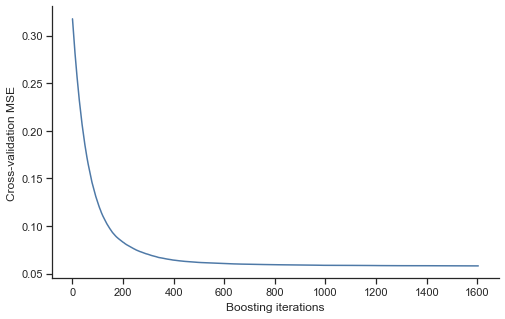

In [29]:
fig, ax = plt.subplots(figsize=(8,5))

plt.plot(history['l2-mean'])

ax.set_ylabel('Cross-validation MSE')
ax.set_xlabel('Boosting iterations')

sns.despine()
plt.show()

## 4.4 Hyperparameter optimisation

Hyperparameter optimisation is one of the most difficult aspects of boosting, as we have many hyperparameters to tune.

An important trick to tune boosting models is to keep the learning rate fixed. Lower learning rates are better but increase the computational cost since we need more trees to achieve any given level of performance.  A common approach is to set a higher learning rate to speed up hyperparameter optimisation and reduce it later to fit the final version of the model.

The next cell implements a general approach for optimising the hyperparameters, taking advantage of early stopping. 

In [30]:
# We have to reconstruct the dataset to tune min_data_in_leaf
train_data = lgb.Dataset(X_train, y_train)
valid_data = lgb.Dataset(X_valid, y_valid, reference = train_data)

from optuna.samplers import TPESampler

def objective(trial):
    
    params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01, 
    'num_leaves': trial.suggest_int('num_leaves', 2, 64),
    'lambda_l1': trial.suggest_loguniform('lambda_l1',  1e-8, 10), 
    'lambda_l2': trial.suggest_loguniform('lambda_l2',  1e-8, 10), 
    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
    'feature_fraction':  trial.suggest_uniform('feature_fraction', 0.5, 1.0),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 128), 
    'feature_pre_filter': False,
    'verbosity': -1,
     }
    
    # Cross-validation 
    history = lgb.cv(params, train_data, num_boost_round=5000, 
                     nfold=5, stratified=False, early_stopping_rounds=50, verbose_eval=0)
    
    # Save full set of parameters
    trial.set_user_attr('params', params)
    
    # Save the number of boosting iterations selected by early stopping
    trial.set_user_attr('num_boost_round', len(history['l2-mean']))
    
    return history['l2-mean'][-1] # returns CV error for the best trial

sampler = TPESampler(seed = 42) 
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=500, timeout=120)  

# Important! The higher the timeout, the better the chances of finding a good configuration. 
# The time budget should be much higher in a real application.

[I 2022-05-01 09:20:16,519] A new study created in memory with name: no-name-72d1f904-d596-4f3f-b604-a8a6e9ccbb3d
[I 2022-05-01 09:20:27,343] Trial 0 finished with value: 0.05946602337258887 and parameters: {'num_leaves': 25, 'lambda_l1': 3.6010467344475403, 'lambda_l2': 0.038720902953704193, 'bagging_fraction': 0.7993292420985183, 'bagging_freq': 2, 'feature_fraction': 0.5779972601681014, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.05946602337258887.
[I 2022-05-01 09:20:31,972] Trial 1 finished with value: 0.060080238977065915 and parameters: {'num_leaves': 56, 'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682, 'bagging_fraction': 0.5102922471479012, 'bagging_freq': 10, 'feature_fraction': 0.9162213204002109, 'min_data_in_leaf': 28}. Best is trial 0 with value: 0.05946602337258887.
[I 2022-05-01 09:20:36,279] Trial 2 finished with value: 0.06124677195245674 and parameters: {'num_leaves': 13, 'lambda_l1': 4.4734294104626844e-07, 'lambda_l2': 5.4724296420321

We can retrieve the best parameters as follows.

In [31]:
params = study.best_trial.user_attrs['params']
num_trees = study.best_trial.user_attrs['num_boost_round']

print(f'Number of boosting iterations: {num_trees} \n')

print('Best parameters:')
params 

Number of boosting iterations: 1805 

Best parameters:


{'objective': 'regression',
 'boosting_type': 'gbdt',
 'learning_rate': 0.01,
 'num_leaves': 33,
 'lambda_l1': 0.022657024151623434,
 'lambda_l2': 5.319049072944658,
 'bagging_fraction': 0.9661451709558938,
 'bagging_freq': 1,
 'feature_fraction': 0.6990216711100883,
 'min_data_in_leaf': 2,
 'feature_pre_filter': False,
 'verbosity': -1}

With some many hyperparameters, it's helpful to know which ones make the most difference for the quality of the model. The `get_param_importances` function from Optuna does exactly this.  

In [32]:
importance = optuna.importance.get_param_importances(study)

importance

OrderedDict([('min_data_in_leaf', 0.810966816811313),
             ('num_leaves', 0.09452233069449957),
             ('bagging_fraction', 0.06519456344827886),
             ('feature_fraction', 0.017382171345485427),
             ('bagging_freq', 0.006697599369035338),
             ('lambda_l2', 0.004910776023685505),
             ('lambda_l1', 0.00032574230770233075)])

## 4.5 Optuna integration (extra material) 

*This is extra material as the tutorial probably won't have time to cover it*.

Optuna also has a LightGBM integration with useful features. For example, we can modify the above code to prune unpromising trials.

In [29]:
# skip running this cell if you want to save time

from optuna.integration import LightGBMPruningCallback

def objective(trial):
    
    params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': trial.suggest_int('num_leaves', 2, 64),
    'lambda_l1': trial.suggest_loguniform('lambda_l1',  1e-8, 10.0), 
    'lambda_l2': trial.suggest_loguniform('lambda_l2',  1e-8, 10.0), 
    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
    'feature_fraction':  trial.suggest_uniform('feature_fraction', 0.3, 1.0),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 128),
    'feature_pre_filter': False,
    'verbosity': -1,
     }
    
    # Instantiate pruning callback
    pruning_callback =  LightGBMPruningCallback(trial, 'l2')
    
    # LightGBM cross-validation
    history = lgb.cv(params, train_data, num_boost_round = 5000, 
                 nfold = 5, stratified = False, early_stopping_rounds = 100,
                 callbacks = [pruning_callback])
    
    # Save full set of parameters
    trial.set_user_attr('params', params)
    
    # Save the number of boosting iterations selected by early stopping
    trial.set_user_attr('num_boost_round', len(history['l2-mean']))
    
    return history['l2-mean'][-1] # returns CV error for the best trial

# Instantiating the sampler to set the random seed
sampler = TPESampler(seed=42) 

# Instantiating the pruner
# The min_resource should be the minimum number of trees required to reasonably judge performance
# This can be tricky to get it right for boosting
# See the notes in the documentation:
# https://optuna.readthedocs.io/en/stable/reference/generated/optuna.pruners.HyperbandPruner.html
pruner = optuna.pruners.HyperbandPruner(min_resource = 100, max_resource = 'auto', reduction_factor = 3)

# A simpler alternative is the median pruner
# This method prunes trials with partial performance below the median of previous trials 
#pruner = optuna.pruners.MedianPruner(n_startup_trials = 10, n_warmup_steps = 500, interval_steps = 5)

study = optuna.create_study(direction='minimize', sampler = sampler, pruner = pruner)
study.optimize(objective, n_trials = 500, timeout= 120)

[I 2022-03-20 15:46:12,075] A new study created in memory with name: no-name-4da063c5-7298-4ff5-9583-5a8808a04188
[I 2022-03-20 15:46:20,479] Trial 0 finished with value: 0.05955663464903803 and parameters: {'num_leaves': 25, 'lambda_l1': 3.6010467344475403, 'lambda_l2': 0.038720902953704193, 'bagging_fraction': 0.7993292420985183, 'bagging_freq': 2, 'feature_fraction': 0.40919616423534183, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.05955663464903803.
[I 2022-03-20 15:46:24,062] Trial 1 finished with value: 0.06093092323582927 and parameters: {'num_leaves': 56, 'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682, 'bagging_fraction': 0.5102922471479012, 'bagging_freq': 10, 'feature_fraction': 0.8827098485602951, 'min_data_in_leaf': 28}. Best is trial 0 with value: 0.05955663464903803.
[I 2022-03-20 15:46:27,797] Trial 2 finished with value: 0.06114055064000443 and parameters: {'num_leaves': 13, 'lambda_l1': 4.4734294104626844e-07, 'lambda_l2': 5.4724296420321

[I 2022-03-20 15:47:56,366] Trial 37 finished with value: 0.0591684262618344 and parameters: {'num_leaves': 42, 'lambda_l1': 0.00044263577176833704, 'lambda_l2': 9.271022274263766, 'bagging_fraction': 0.837855818432276, 'bagging_freq': 6, 'feature_fraction': 0.8198030841168825, 'min_data_in_leaf': 34}. Best is trial 31 with value: 0.05759037895929562.
[I 2022-03-20 15:48:01,195] Trial 38 finished with value: 0.0567413566938767 and parameters: {'num_leaves': 55, 'lambda_l1': 0.002552504259894434, 'lambda_l2': 7.73599703211955e-05, 'bagging_fraction': 0.8721908891061252, 'bagging_freq': 3, 'feature_fraction': 0.745591971818633, 'min_data_in_leaf': 19}. Best is trial 38 with value: 0.0567413566938767.
[I 2022-03-20 15:48:05,787] Trial 39 finished with value: 0.057093425116279725 and parameters: {'num_leaves': 64, 'lambda_l1': 0.0002521693683768883, 'lambda_l2': 0.00019917889167839206, 'bagging_fraction': 0.8730220271843254, 'bagging_freq': 2, 'feature_fraction': 0.7182129011851236, 'min_d

Observe how pruning allowed Optuna to execute more trials within the allocated time. In practice, HyperBand needs [more trials](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.pruners.HyperbandPruner.html) to work well with TPE sampling. 

In [30]:
params = study.best_trial.user_attrs['params']
num_trees = study.best_trial.user_attrs['num_boost_round']

print(f'Number of boosting iterations: {num_trees} \n')

print('Best parameters:')
params 

Number of boosting iterations: 255 

Best parameters:


{'objective': 'regression',
 'boosting_type': 'gbdt',
 'learning_rate': 0.05,
 'num_leaves': 55,
 'lambda_l1': 0.002552504259894434,
 'lambda_l2': 7.73599703211955e-05,
 'bagging_fraction': 0.8721908891061252,
 'bagging_freq': 3,
 'feature_fraction': 0.745591971818633,
 'min_data_in_leaf': 19,
 'feature_pre_filter': False,
 'verbosity': -1}

The `LightGBMTunerCV` function implements an efficient algorithm for tuning LightGBM that has been found to work well in Kaggle competitions.`LightGBMTuner` is a similar function that uses a validation set. Instead of jointly optimising the hyperparameters as above, this implementation optimises one hyperparameter at time. The optimised hyperparameters are `lambda_l1`, `lambda_l2`, `num_leaves`, `feature_fraction`, `bagging_fraction`, `bagging_freq` and `min_data_in_leaf`.  


This method runs faster than the more generic hyperparameter optimisation procedure from above, making it a good starting point. Either algorithm can perform better depending on the problem. 

In [31]:
# skip running this cell if you want to save time

import optuna.integration.lightgbm as lgb

dtrain = lgb.Dataset(X_train, y_train)
    
params = {
    'objective': 'regression',
    'metric': 'l2',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'feature_pre_filter': False,
    'verbosity': -1,
}

tuner = lgb.LightGBMTunerCV(params, dtrain, num_boost_round = 5000, early_stopping_rounds = 100, 
                            verbose_eval=1000, time_budget = 120, nfold=5, stratified = False)

tuner.run()

[I 2022-03-20 15:48:14,092] A new study created in memory with name: no-name-6413086f-8100-405a-8f15-81e4464d8b3f
num_leaves, val_score: 0.057090:  55%|##########################9                      | 11/20 [00:56<00:42,  4.69s/it]

[1000]	cv_agg's l2: 0.0595661 + 0.00446314


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]


Here are the selected hyperparameters.

In [32]:
print('Best params:')

tuner.best_params

Best params:


{'objective': 'regression',
 'metric': 'l2',
 'boosting_type': 'gbdt',
 'learning_rate': 0.05,
 'feature_pre_filter': False,
 'verbosity': -1,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 57,
 'feature_fraction': 0.7,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

## 4.6 Final LightGBM model

Finally, the next cell trains the final version of the LightGBM model for this tutorial. To get the final hyperparameters, I ran the Optuna study with pruning for ten minutes. 

In [33]:
import lightgbm as lgb

params = {
 'objective': 'regression',
 'boosting_type': 'gbdt',
 'learning_rate': 0.01,
 'num_leaves': 45,
 'lambda_l1': 0.027109795180157614,
 'lambda_l2': 1.3211122996540583e-06,
 'bagging_fraction': 0.9303390497096511,
 'bagging_freq': 8,
 'feature_fraction': 0.6954068017048125,
 'min_data_in_leaf': 2}

lgbm = lgb.train(params, train_data, num_boost_round = 3996, verbose_eval = False)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 4128, number of used features: 8
[LightGBM] [Info] Start training from score 0.573084


# 5. Benchmark Models

## 5.1 Linear Regression

In [34]:
# This code is  just for running

ols = LinearRegression()
ols.fit(X_train, y_train)

LinearRegression()

## 5.2 Regression Tree


In [35]:
# This code is  just for running
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(min_samples_leaf=5)
path = model.cost_complexity_pruning_path(X_train, y_train)
alphas = path.ccp_alphas

search_space = {
    'ccp_alpha': alphas,
}

tree_search = GridSearchCV(model, search_space, cv = 5)
tree_search.fit(X_train, y_train)

tree = tree_search.best_estimator_

print('Best parameters found by grid search:', tree_search.best_params_, '\n')

Best parameters found by grid search: {'ccp_alpha': 0.00015302392695081555} 



## 5.3 Random forest

In [36]:
# This code is  just for running 

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=1000, max_features = 3, min_samples_leaf= 1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_features=3, n_estimators=1000)

# 6. Model selection

The following table shows the validation results. Boosting clearly outperforms the linear regression, regression tree, and random forest.

LightGBM is the best model among the boosting variations, which is to be expected since we put more effort into it. CatBoost lived up to the promise of performing well with default settings, at least for this problem.  XGBoost probably needs more tuning. The results are consistent with  three packages tend to perform better than scikit-learn, as seen in these results. 

An important note: a complete analysis based on all the tutorials so far should also include a GAM and and model stacking. 

In [37]:
# Auxiliary code - important to understand but similar to previous tutorials

columns=['Test RMSE', 'Test R$^2$', 'Test MAE']
rows=['Linear regression', 'Regression tree', 'Random forest', 'GBM', 'Histogram-based GBM',
      'XGBoost', 'CatBoost', 'LightGBM']

results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods = [ols, tree, rf, gb, hgb, xgbst, cb, lgbm]

for i, method in enumerate(methods):

    y_pred = method.predict(X_valid)
    
    # The linear regression model is severely affected by outliers
    if method == ols:
        y_pred[y_pred>y_train.max()] = y_train.max()
        y_pred[y_pred<y_train.min()] = y_train.min()
    
    results.iloc[i,0] = np.sqrt(mean_squared_error(y_valid, y_pred))
    results.iloc[i,1] = r2_score(y_valid, y_pred)
    results.iloc[i,2] = mean_absolute_error(y_valid, y_pred)

results.round(3)

,Test RMSE,Test R$^2$,Test MAE
Linear regression,0.335,0.655,0.248
Regression tree,0.306,0.711,0.222
Random forest,0.253,0.803,0.182
GBM,0.232,0.834,0.162
Histogram-based GBM,0.234,0.831,0.166
XGBoost,0.230,0.837,0.162
CatBoost,0.227,0.841,0.160
LightGBM,0.225,0.844,0.157
